# Predicting NHL Clutch Goalscorers

This project applies machine learning to identify and predict NHL forwards who excel in “clutch” situations (close, tied, and overtime games). The goal is not only to measure  clutch performance but to model expected clutch scoring given a player’s underlying metrics.

The final model has been deployed to a [Streamlit Dashboard](https://shak789-nhl-clutch-goalscorers-app-dpjtq2.streamlit.app/) that is updated at 9 a.m. EST daily.

### 1. Data Sources
* NHL API: Player biographical information and traditional goal statistics
* Natural Stat Trick:
  - Goals scored in tied, one-goal deficit, and overtime situations
  - Advanced performance metrics (scoring chances, assists, ice time, rebounds)

### 2. Establishing a Definition of Clutch
I computed a "clutch score" for each player by weighting their goals in critical game situations:

- Goals per game when the team is down by one goal (45% weight)
- Goals per game when the game is tied (35% weight)
- Goals per game in overtime (20% weight)

Goals when the team is down by one goal received the highest weight because situations where the team is down by one goal are more high pressure than when the game is tied. Overtime goals received the lowest weight because they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from regular 5v5.

### 3. Building a Classification Model
I first tried classification since it seemed logical to classify players as "clutch" and "non-clutch". I set thresholds for the clutch score and trained an XGBoost model on data from the 2020-2021 to the 2023-2024 NHL season. The model used various underlying performance metrics such as expected goals, high-danger scoring chances, shot attempts. While the model was successful in identifying elite players and those below average, it struggled with players who fell near the classification boundaries, where small differences in their stats made it difficult to confidently label them as clutch or non-clutch. 

### 4. Switching to a Regression Model
Linear regression was a more feasible approach since many of the features were strongly correlated with a clutch score. It would be easier to predict a player's clutch score rather than assigning the player an ambiguous label.  

However, there was multicollinearity among features, which would lead to instability in coefficients and make it difficult to interpret the impact of features on the clutch score. Therefore, a small subset of features were kept (scoring chances, assists, time on ice, rebounds created, offensive zone starts). 

I also refined the model by using Ridge regression and performed cross-validation to ensure there was less overfitting.

### 5. Dealing with Outliers
I used Cook's distance to identify influential points. The model underpredicted the clutch score of elite players because their feature stats set a "ceiling" for their clutch ability. The model also overestimated some elite players who had strong underlying metrics but did not perform well in clutch games. In addition, the model struggled with below-average players who scored clutch goals at a rate that did not match their advanced stats.  This prompted me to use a log transformation on the clutch score, which enabled the model to generate better predictions for elite players and reduced the number of influential points. 

After the transformation, the model still undervalued some players who performed better in close and tied situations than their metrics suggest. While influential points are often viewed negatively, they can show which players perform better under pressure than their stats suggest. 

### 6. Prediction Intervals
95% prediction intervals were generated for each player. If actual clutch scores fall outside the intervals, this indicates that clutch performance is significantly different from expectations. The intervals are generated using a bootstrap procedure with resampled residual noise, which ensures that the intervals reflect randomness in clutch performance.

### 7. Shap Values
SHAP values were calculated to explain which features most influenced each player's prediction.

### 8. Using the Model on a Final Test Set
The model was tested on player data from the 2024-2025 season to the current point of the 2025-2026 season. The R² of 70% indicates the model explains 70% of variance in clutch performance, which is strong given the inherent randomness in clutch situations. 


### Imports
These are the necessary imports for the project.

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
from sklearn.utils import resample

import shap

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

import joblib

### NHL API

In [6]:
all_seasons = []

for season in range(2021, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009        Zdeno Chara            D           72       12        0   
1      8466138       Joe Thornton            C           34        5        0   
2      8469455       Jason Spezza            C           71       13        0   
3      8470281       Duncan Keith            D           64       20        0   
4      8470595         Eric Staal            C           72       15        0   
...        ...                ...          ...          ...      ...      ...   
1250   8484314       Jiri Smejkal            L           20        1        0   
1251   8484321  Nikolas Matinpalo            D            4        0        0   
1252   8484325    Waltteri Merela            C           19        0        0   
1253   8484326        Patrik Koch            D   

### Cleaning the NHL API Data
-  Only forwards are included since defensemen score at different rates. 
-  Players must have appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.

In [8]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 100)]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_game'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

### Scraping Data from Natural Stat Trick

In [10]:
start_season = "20212022"
end_season = "20232024"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [11]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
    "on_ice": (on_ice_url, '')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]
on_ice_df = dataframes["on_ice"]
on_ice_df.columns = on_ice_df.columns.str.replace('\xa0', ' ')

### Cleaning Data from Natural Stat Trick
Similar to the NHL API data, only players who have played at least 60 games are included. The dataframes have already been filtered for forwards through the URLs.


In [13]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]
on_ice_df = on_ice_df[['Player', 'Off. Zone Starts', 'On The Fly Starts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df, on_ice_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 100]

rename_columns = {
    'Shots': 'shots',
    'Rebounds Created': 'rebounds_created',
    'Off. Zone Starts': 'off_zone_starts',
    'On The Fly Starts': 'on_the_fly_starts'
}

merged_natural_stat.rename(columns = rename_columns, inplace=True)

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [15]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak", "Zack Bolduc", "Frederic Gaudreau"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak", "Zachary Bolduc", "Freddy Gaudreau"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [17]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals = merged_clutch_goals.dropna()

### Changing Columns
Compute per game stats to accurately compare players.

In [19]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created', 'off_zone_starts', 'on_the_fly_starts']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from regular 5v5.

In [21]:
merged_clutch_goals['clutch_score'] = (
    0.45 * merged_clutch_goals['goals_down_by_one_per_game'] + 
    0.35 * merged_clutch_goals['goals_when_tied_per_game'] + 
    0.2 * merged_clutch_goals['ot_goals_per_game']
)

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [23]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
277,Auston Matthews,14.96,1.0
205,David Pastrnak,13.50,2.0
267,Kirill Kaprizov,13.25,3.0
192,Leon Draisaitl,12.26,4.0
232,Connor McDavid,12.16,5.0
131,Filip Forsberg,11.44,6.0
388,Jack Hughes,11.01,7.0
213,Brayden Point,10.81,8.0
301,Tage Thompson,10.64,9.0
37,Steven Stamkos,10.52,10.0


### Distribution of Clutch Scores
As shown by the histogram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players


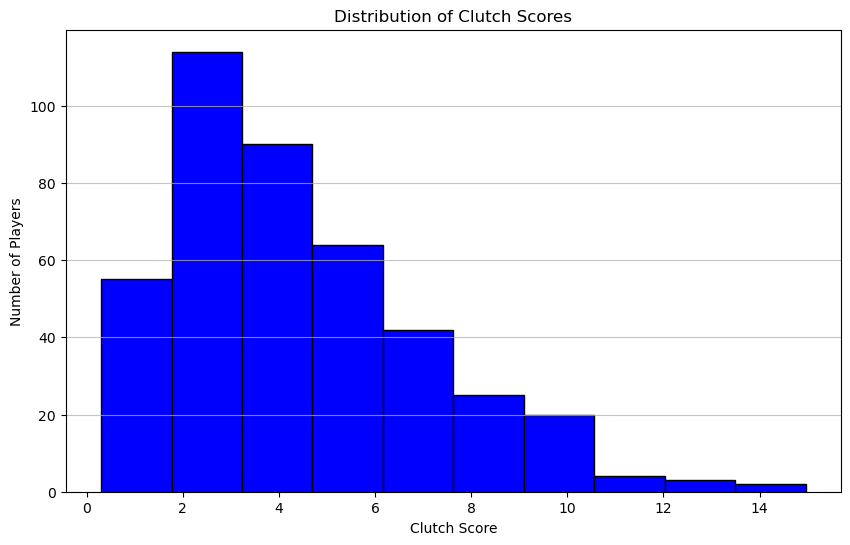

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundaries?

In [27]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)

def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch".

In [29]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    356
1     63
Name: count, dtype: int64

### Setting up a Classification Model

My initial approach was to select various classification models (e.g. XGBoost, random forest, KNN) and compare them with the Friedman statistical test. I started working on an XGBoost model, but then realized that a classification approach was noidealea.


### Starting with XGBoost

A full glossary of the features can be found on the __[Natural Stat Trick website.](https://www.naturalstattrick.com/glossary.php?players)__


In [32]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 
         'off_zone_starts_per_game', 'on_the_fly_starts_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Inflated Accuracy

The model's accuracy appears to be quite high (approximately 90%), but this is most likely due to the high class imbalance. The model can predict the majority class most of the time, without effectively learning to identify the minority class.

The model seems to have a high precision and low recall. It is very cautious about predicting the minority class (clutch goalscorers), which results in fewer false positives. So when the model predicits positive, it is mostly correct. However, this means that the model misses many clutch goalscorers and has a low recall. 

The F1 score is pulled down by the low recall to highlight the model's issues with rarely predicting the positive class and missing clutch goalscorers.

In [34]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.040124
score_time        0.009597
test_accuracy     0.878339
test_precision    0.730435
test_recall       0.578571
test_f1           0.588824
dtype: float64

### Learning Curves
The learning curves plot the log loss of the training against the log loss for cross-validation. The very low log loss for training indicates that the model has nearly 100% accuracy in predicting clutch players from the training data. However, the log loss increases to 0.4 on the cross-validation data. Due to the high negative class imbalance, the model can just predict non-clutch most of the time. When it predicts the positive class, it may not be confident enough which shows the model has memorized the patterns in the training data and cannot generalize to new data during cros- validation
Note: The high imbalance in the dataset means that stratified cross-validation may not be able to create balanced splits, leading to the error message.


C:\Users\Work\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Work\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Work\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Work\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of 

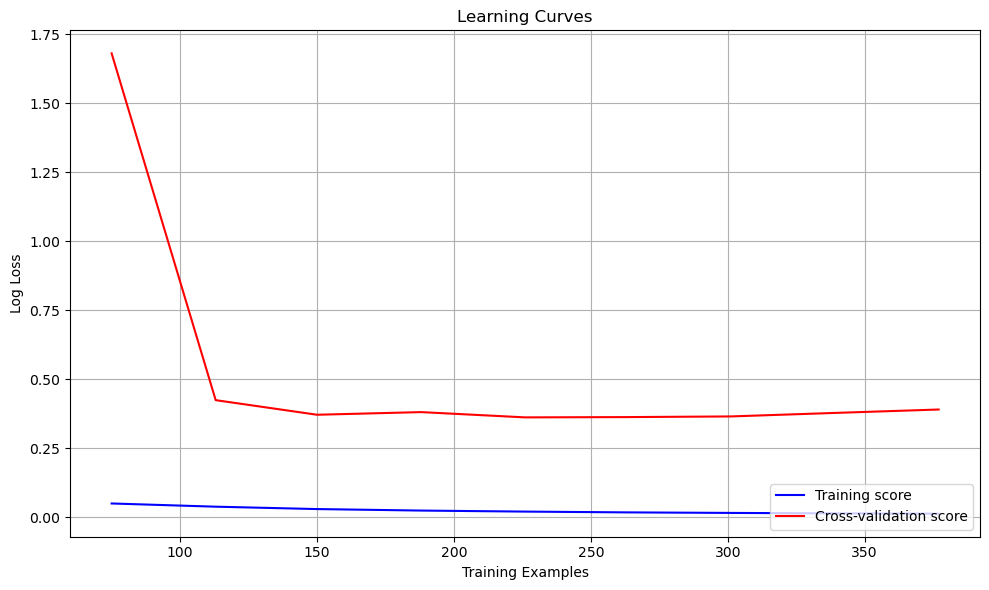

In [36]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Hyperparameter tuning
Hyperparameter tuning involves adjusting parameters to improve the model's metrics and reduce overfitting. These parameters are set before training since the model cannot learn them from the data. Below are hyperparameters that are tuned for the XGBoost model better generalization.


In [38]:
from scipy.stats import randint, uniform

param_grid = {
    'max_depth': randint(2, 6),
    'min_child_weight': randint(2, 4),
    'n_estimators': randint(200, 301), 
    'learning_rate': uniform(0.03, 0.01),
    'reg_alpha': uniform(0.75, 0.6), 
    'reg_lambda': uniform(0.75, 0.6), 
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3) 
}


### Random Search

I have repeated random search multiple times on different train and test splits to obtain a good representation of the model's performance. After each train and test split, the model's class weights are adjusted.


### Results of Hyperparameter Tuning

From the learning curves, it seems that hyperparameter tuning has helped to reduce overfitting.

With regards to the model's performance metrics, it is simply not enough to look at the recall and precision score. We must understand where the model is misclassifying clutch players.

After each randomly selected train test split, I printed out the model's classification results. It appears that the model can correctly classify higher ranked players but struggles with players close to the boundary points (ranks between 45 and 74). The model also incorrectly classifies players with varying performance over the three seasons. 

This makes sense because we are essentially assigning an ambiguous label to a clutch player. Is a player 0n the 84th to 83rd percentile suddenly not clutch? Classification may also have difficulties detecting trends in player performance.


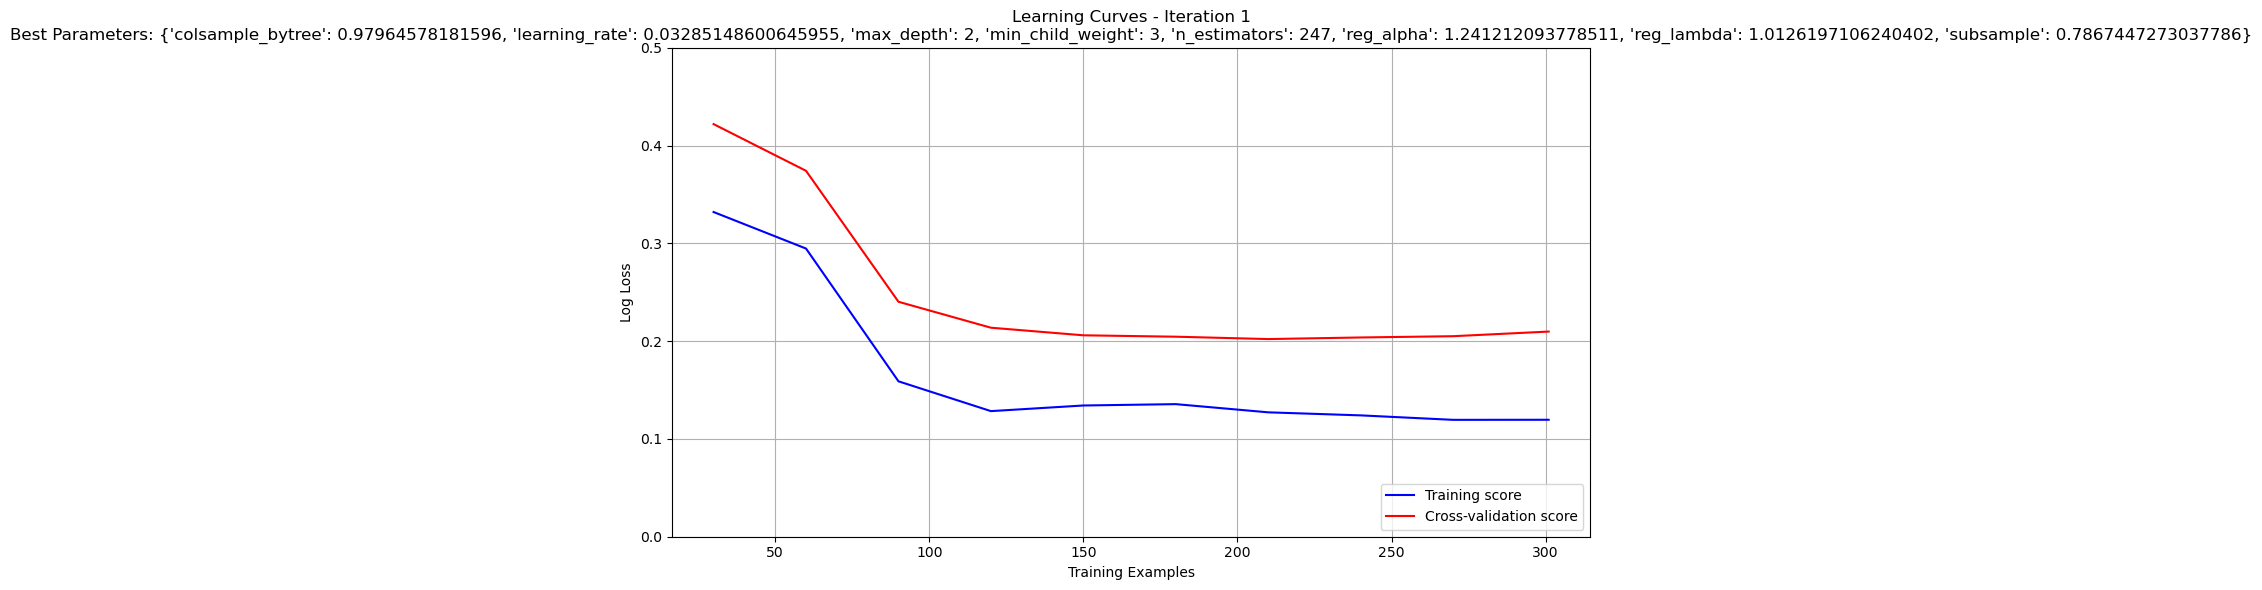


Precision Score:  0.625
Recall Score:  0.7692307692307693

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
205    David Pastrnak                2.0       1          1
294      Jordan Kyrou               56.0       1          1
171  Nathan MacKinnon               18.0       1          1
388       Jack Hughes                7.0       1          1
236    Mikko Rantanen               17.0       1          1
14      Brad Marchand               55.0       1          1
52       John Tavares               45.0       1          1
198      Dylan Larkin               14.0       1          1
262    Artemi Panarin               24.0       1          1
103      Boone Jenner               37.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
111  Mika Zibanejad               29.0       1          0
53     Matt Duchene               52.0       1          0
283  Clayton Keller               25.0       1          0



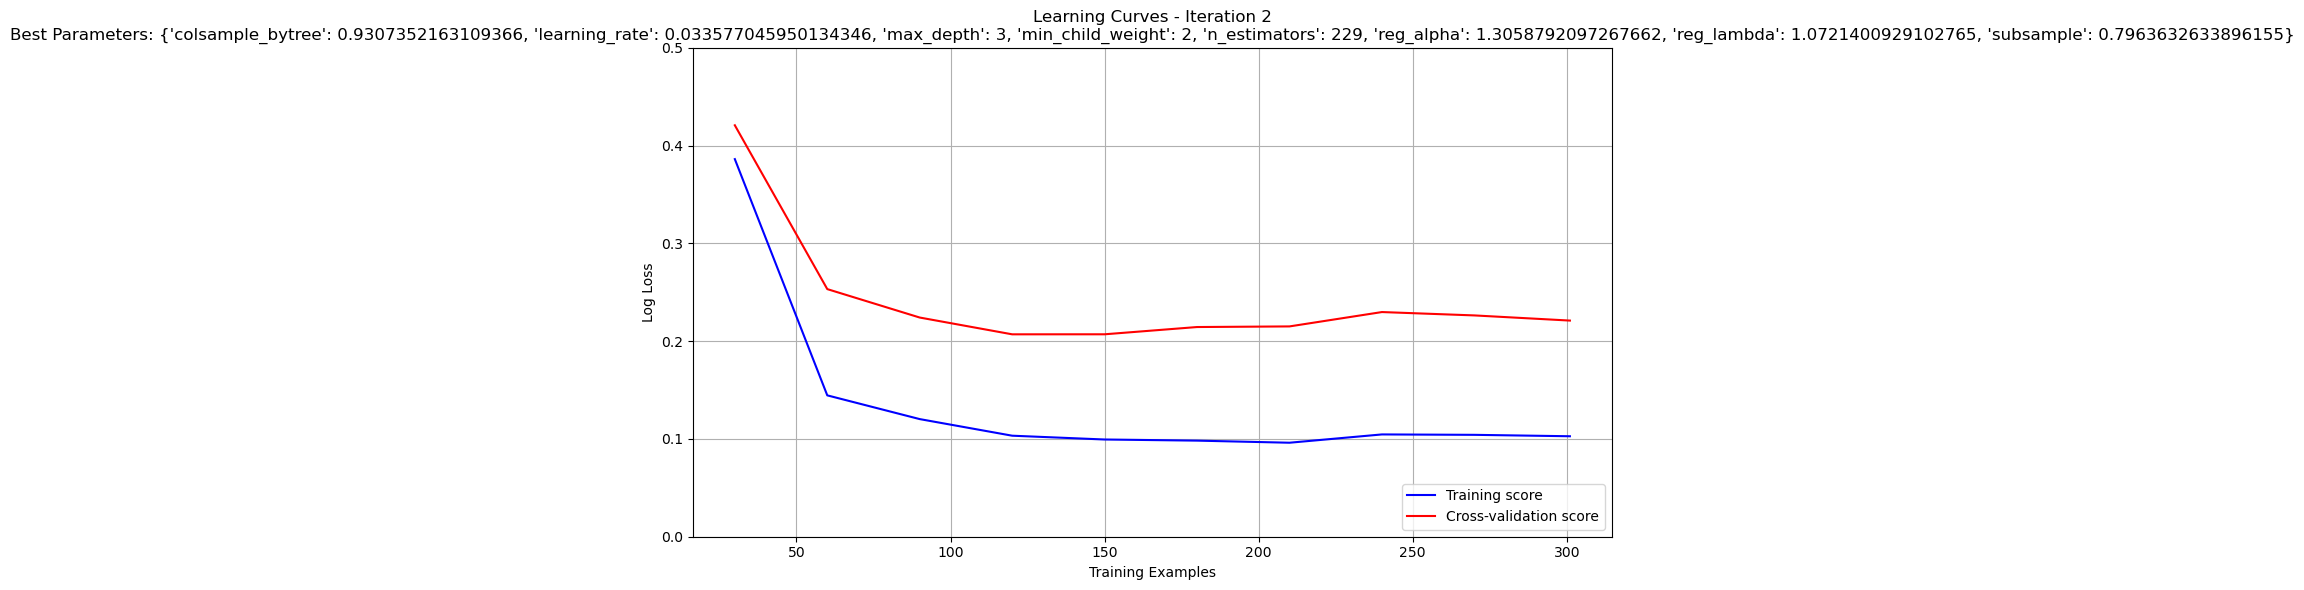


Precision Score:  0.8181818181818182
Recall Score:  0.6923076923076923

Correct Classfications
                Player  clutch_score_rank  Actual  Predicted
255       Mitch Marner               35.0       1          1
333    Jason Robertson               20.0       1          1
233        Jack Eichel               27.0       1          1
282       Patrik Laine               39.0       1          1
229        Kyle Connor               15.0       1          1
5        Alex Ovechkin               63.0       1          1
205     David Pastrnak                2.0       1          1
172  Aleksander Barkov               40.0       1          1
327   Elias Pettersson               49.0       1          1

Missed Cltuch Players
              Player  clutch_score_rank  Actual  Predicted
191     Sam Reinhart               19.0       1          0
283   Clayton Keller               25.0       1          0
213    Brayden Point                8.0       1          0
328  Gabriel Vilardi               

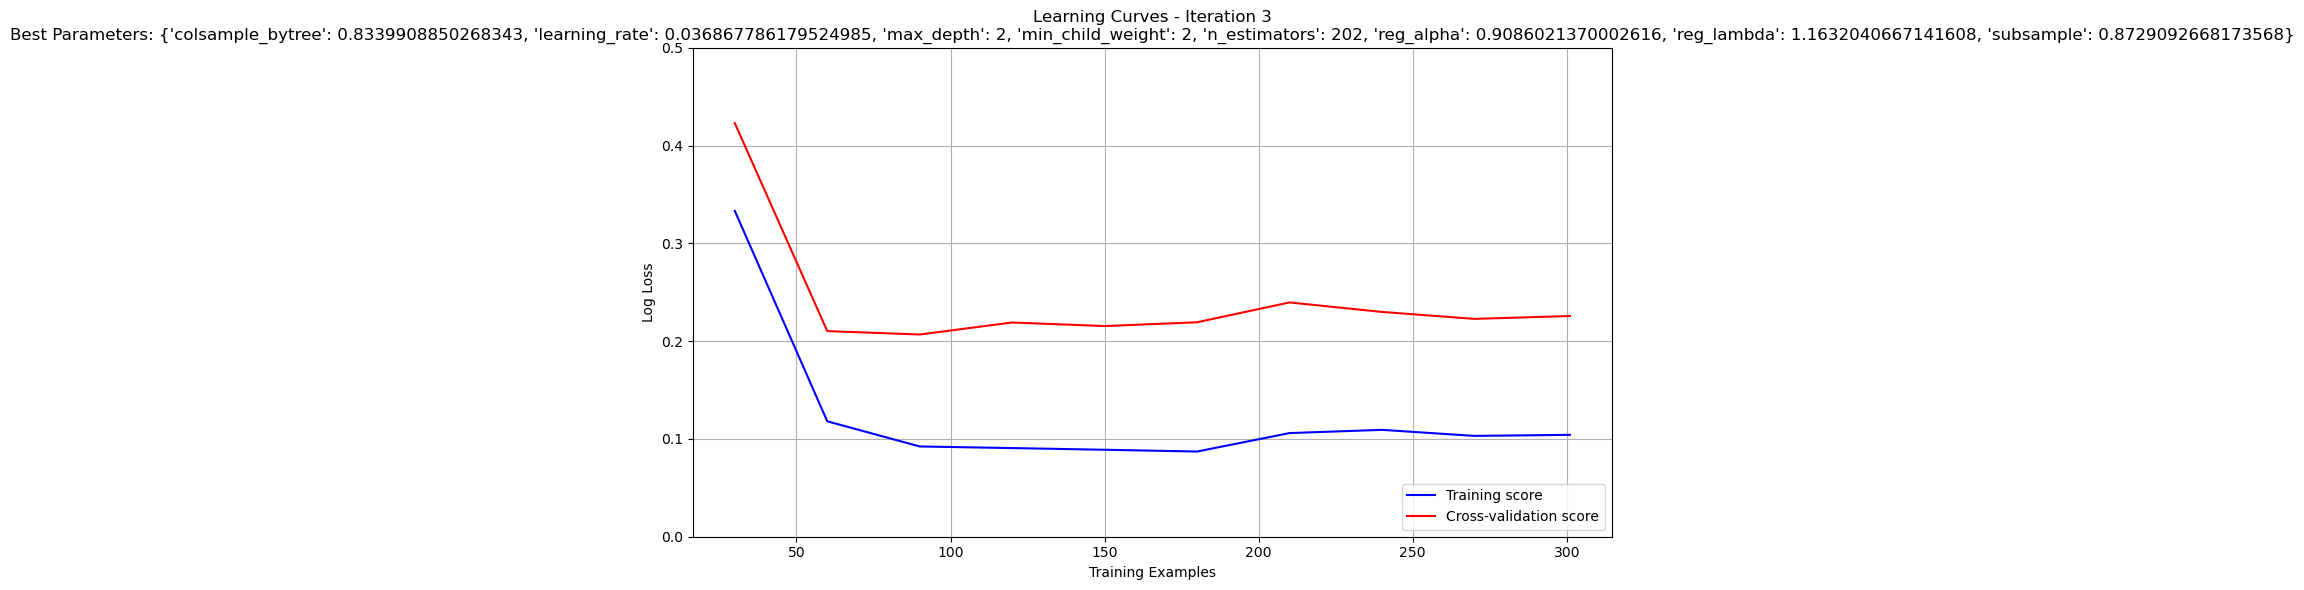


Precision Score:  0.75
Recall Score:  0.6923076923076923

Correct Classfications
              Player  clutch_score_rank  Actual  Predicted
5      Alex Ovechkin               63.0       1          1
333  Jason Robertson               20.0       1          1
205   David Pastrnak                2.0       1          1
255     Mitch Marner               35.0       1          1
206     Adrian Kempe               33.0       1          1
235       Timo Meier               12.0       1          1
388      Jack Hughes                7.0       1          1
262   Artemi Panarin               24.0       1          1
301    Tage Thompson                9.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
370  Kirill Marchenko               53.0       1          0
176         Bo Horvat               21.0       1          0
114       J.T. Miller               50.0       1          0
283    Clayton Keller               25.0       1          0



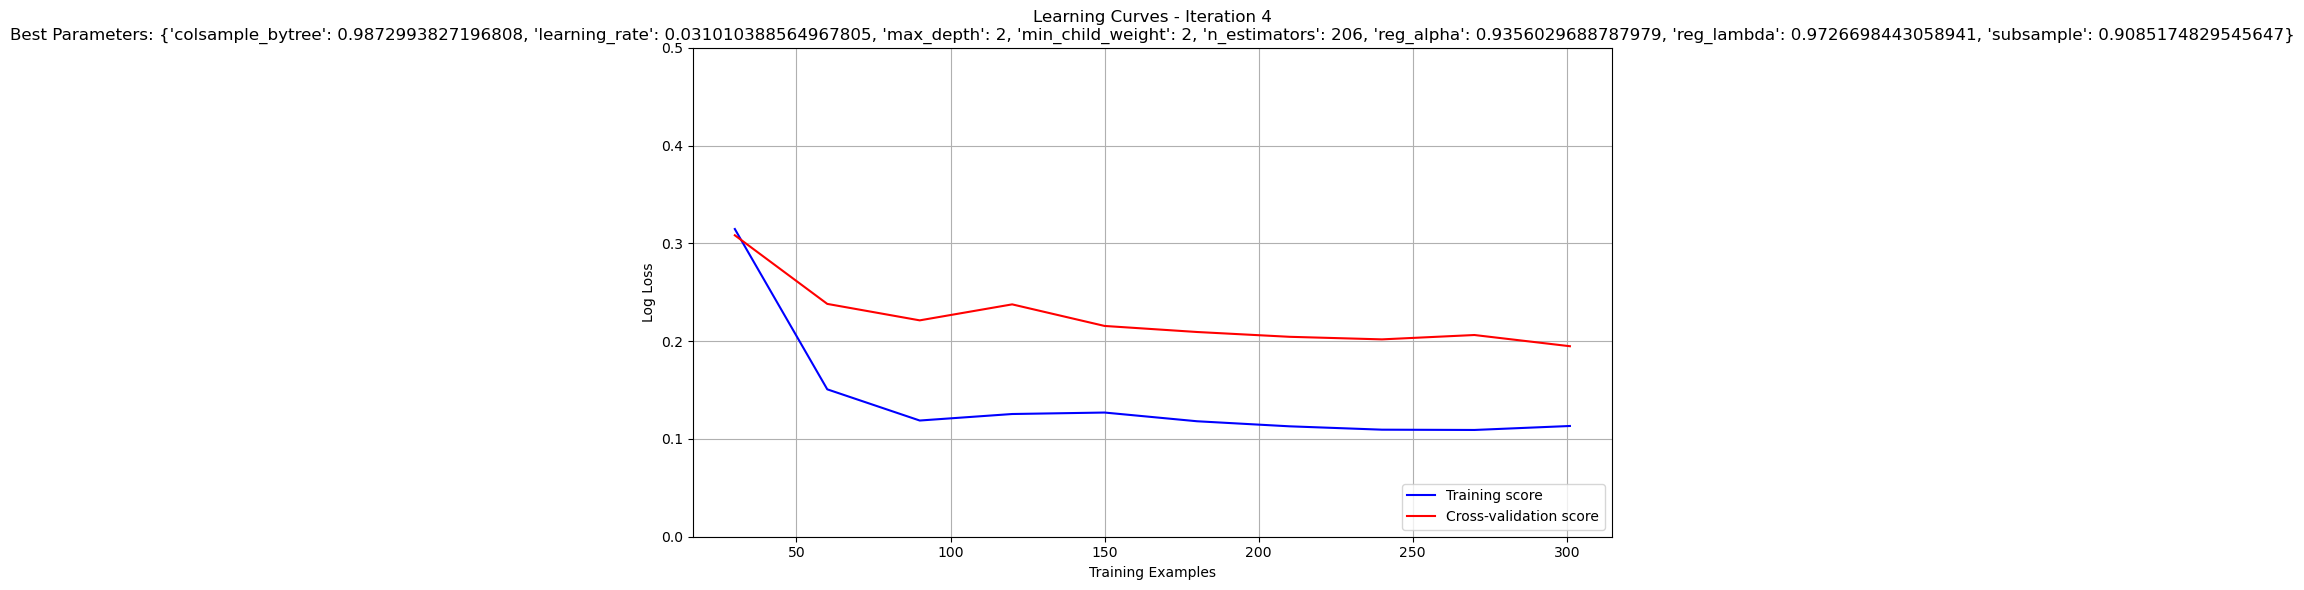


Precision Score:  0.7142857142857143
Recall Score:  0.7692307692307693

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
233       Jack Eichel               27.0       1          1
236    Mikko Rantanen               17.0       1          1
9       Sidney Crosby               28.0       1          1
58      Chris Kreider               32.0       1          1
232    Connor McDavid                5.0       1          1
239     Sebastian Aho               22.0       1          1
131    Filip Forsberg                6.0       1          1
153     Jake Guentzel               47.0       1          1
171  Nathan MacKinnon               18.0       1          1
111    Mika Zibanejad               29.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
370  Kirill Marchenko               53.0       1          0
402     Lucas Raymond               61.0       1          0
92         Mark Stone               60.0 

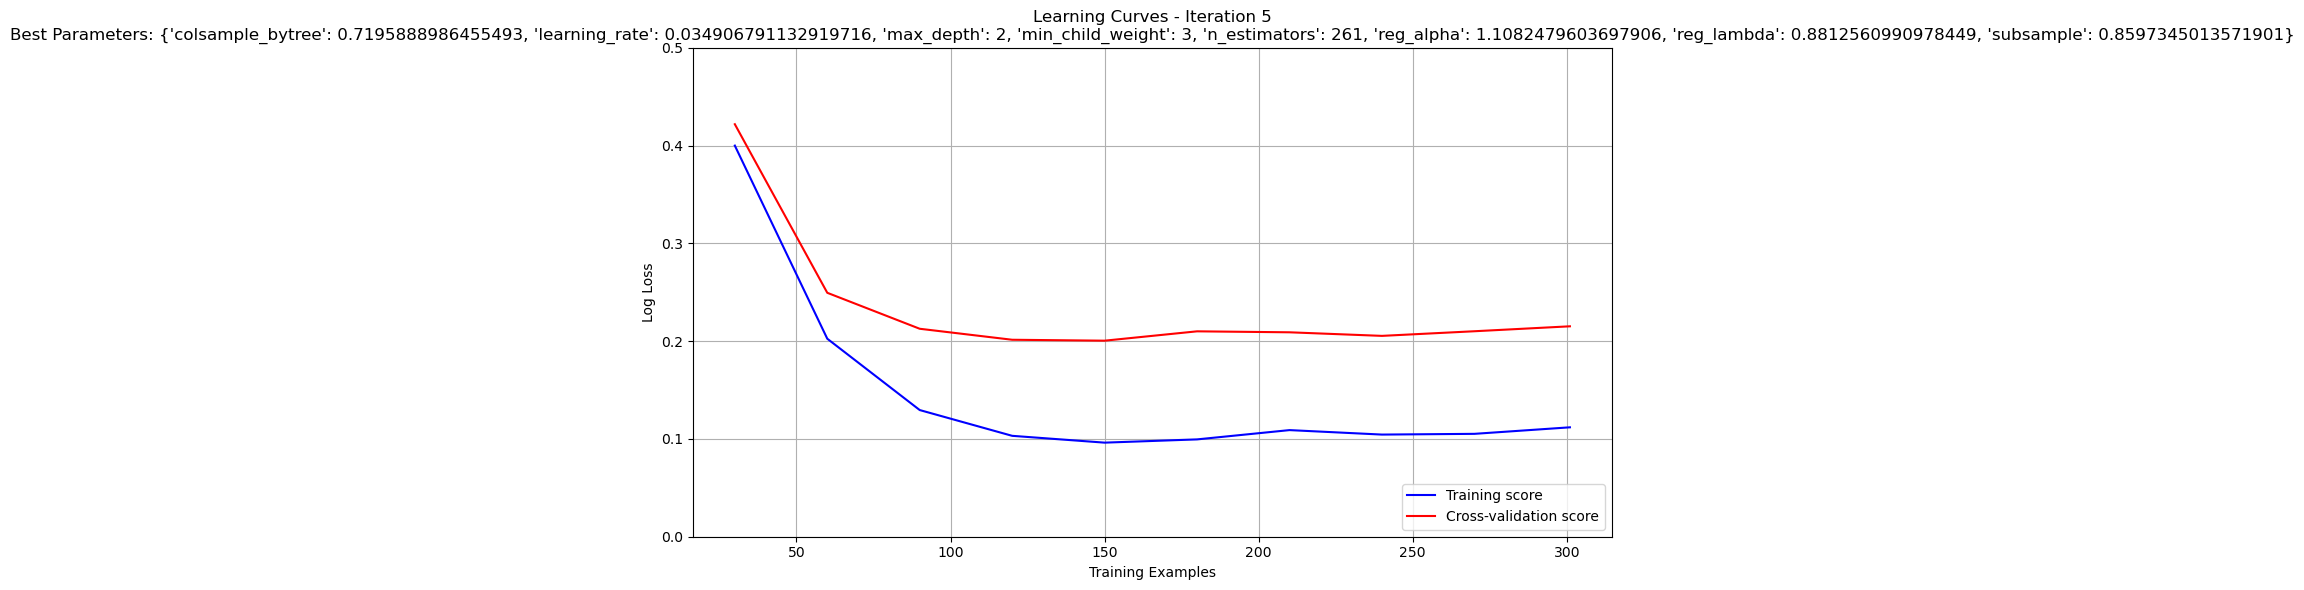


Precision Score:  0.6428571428571429
Recall Score:  0.6923076923076923

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
194  William Nylander               11.0       1          1
262    Artemi Panarin               24.0       1          1
255      Mitch Marner               35.0       1          1
327  Elias Pettersson               49.0       1          1
9       Sidney Crosby               28.0       1          1
37     Steven Stamkos               10.0       1          1
232    Connor McDavid                5.0       1          1
171  Nathan MacKinnon               18.0       1          1
239     Sebastian Aho               22.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
53     Matt Duchene               52.0       1          0
111  Mika Zibanejad               29.0       1          0
191    Sam Reinhart               19.0       1          0
322   Nico Hischier               41.0       1   

In [41]:
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=10)

precision_list = []
recall_list = []
f1_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Log Loss')
    plt.ylim(0, 0.5)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = RandomizedSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, n_jobs = -1, scoring = 'f1')

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("")
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("")

    
    results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[test_y.index, 'Player'],
    'clutch_score_rank': merged_clutch_goals.loc[test_y.index, 'clutch_score_rank'],
    'Actual': test_y,
    'Predicted': y_pred,
    })

    print("Correct Classfications")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 1)])

    print("")

    print("Missed Cltuch Players")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 0)])

    print("")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

### Switching to Regression

Although the classification model does show advantages in correctly classifying some player, I believe that regression is more suitable:

1. Unlike Classification, regression can be used to predict the player's clutch score (a continuous label), rather than assigning them to classes that may not clearly define a "clutch player". This makes the model easier to interpret and leads to more accurate predictions.
2. Regression can account for the trends in player performance and provide better predictions.


### Features
The same features from classification are used. These features show a strong positive correlation with clutch score, which indicates that a linear regression model is suitable


In [44]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 
         'off_zone_starts_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.870929
ixG_per_game                 0.858424
iFF_per_game                 0.874788
iSCF_per_game                0.883971
iHDCF_per_game               0.689704
assists_per_game             0.758345
iCF_per_game                 0.868702
rebounds_created_per_game    0.781486
time_on_ice_per_game         0.791332
off_zone_starts_per_game     0.756099
dtype: float64


### Scatter Plots
The scatter plots further show the strong positive correlation of the features with clutch score.

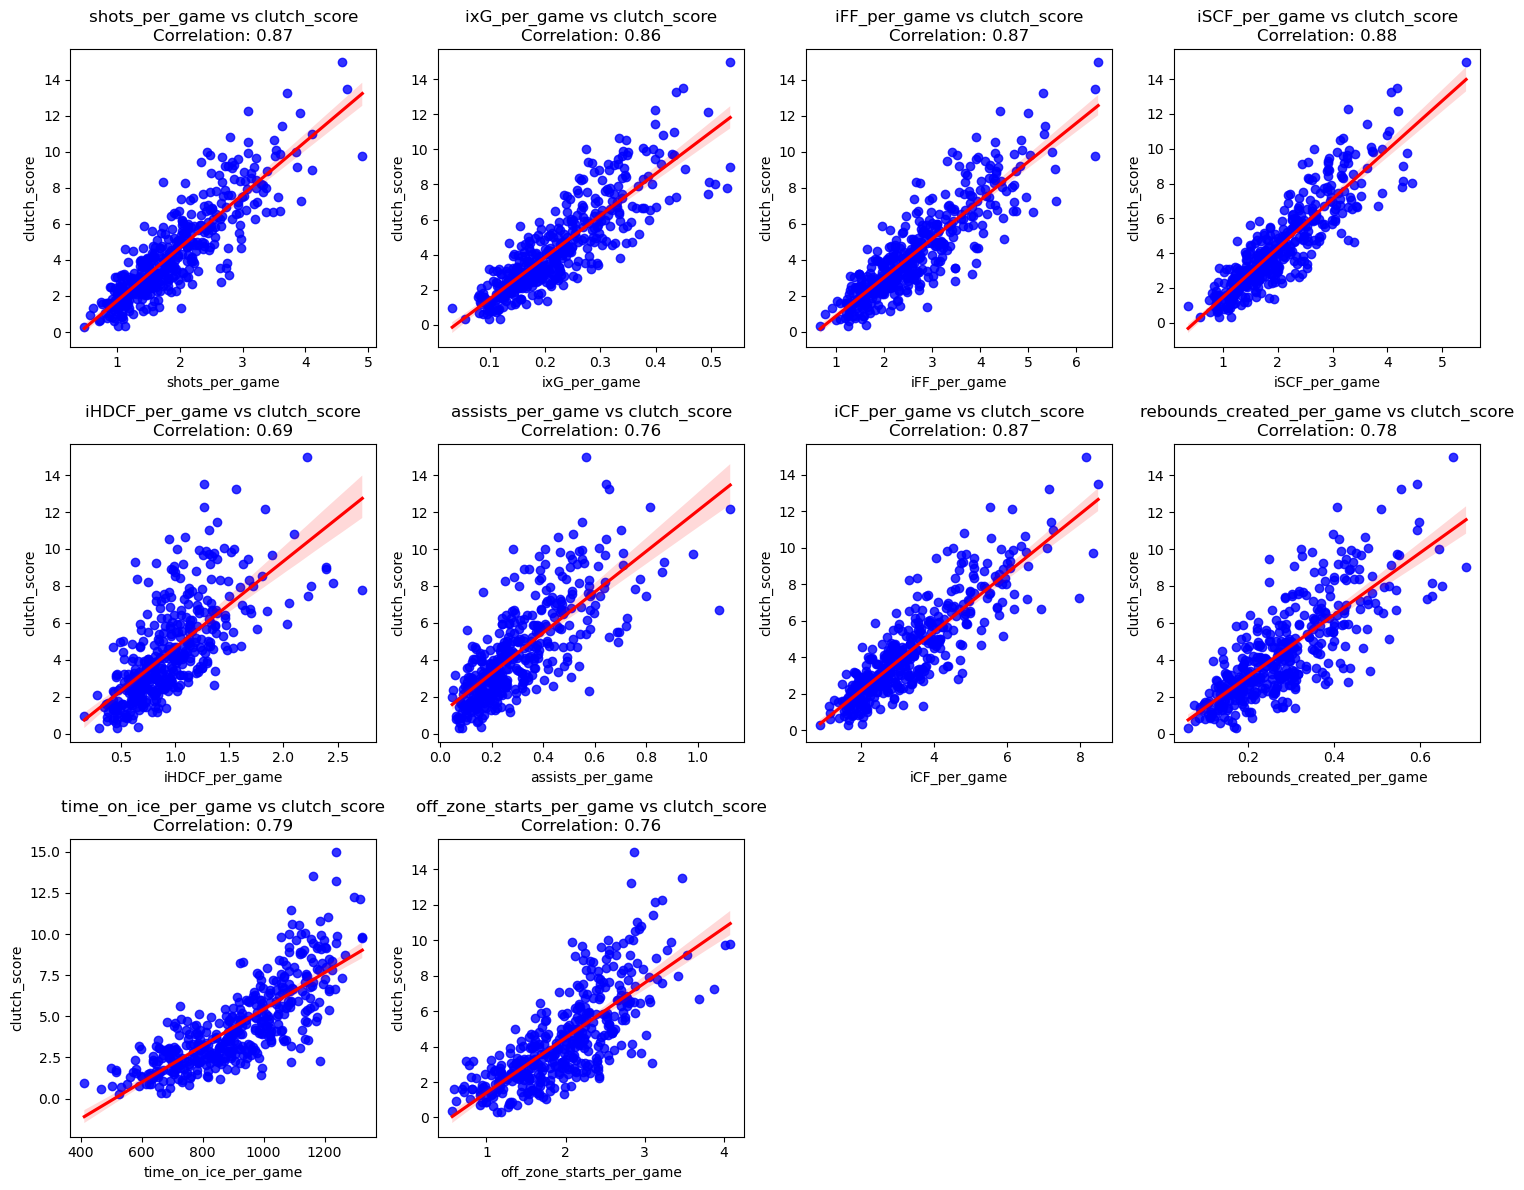

In [46]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 4, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

### Multicollinearity
As the heatmap shows, there is high multicollinearity among features, which would lead to instability in coefficients and make it difficult to interpret the impact of features on the clutch score. Therefore, a small subset of features were kept (scoring chances, assists, time on ice, rebounds created, offensive zone starts).

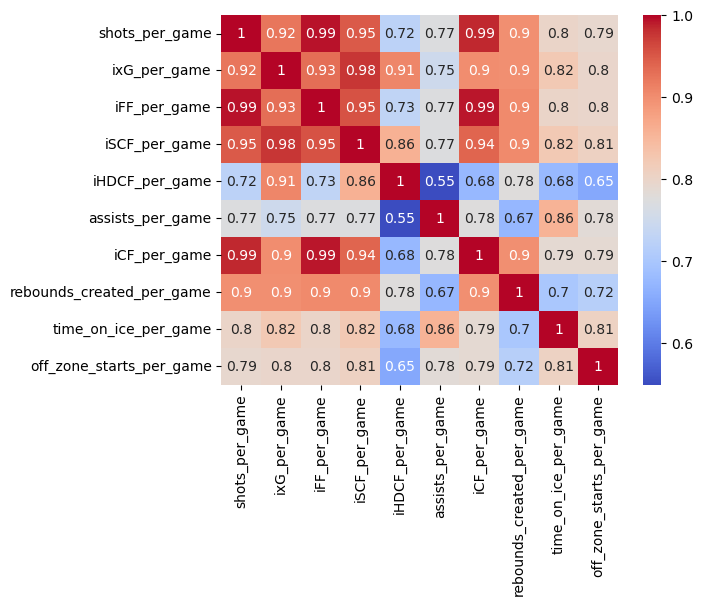

In [48]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

### Ridge Regression
Ridge regression is used to ensure there is less overfitting.
The model shows good performance because it has a low MSE of approximately 1 and R² of approximately 80%. In future sections, the outliers are evaluated to determine the model's limitations which are not obvious with the MSE and R².

In [50]:
x_var = ['iSCF_per_game', 'assists_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 'off_zone_starts_per_game']

X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas = np.logspace(-3, 3, 20)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
median_error = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("Median Error: ", median_error)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.739532865672575
RMSE:  1.3189135171316484
Median Error:  0.8171137231089316
R²:  0.7936333979708128
Adjusted R²:  0.7904971274232567


### Learning Curves

The learning curves do not show significant overfitting. After approximately 250 samples, both training and validation curves converge to an MSE of less than
2 
Thus, Ridge Regression is the correct choice for generalizing the training dat.


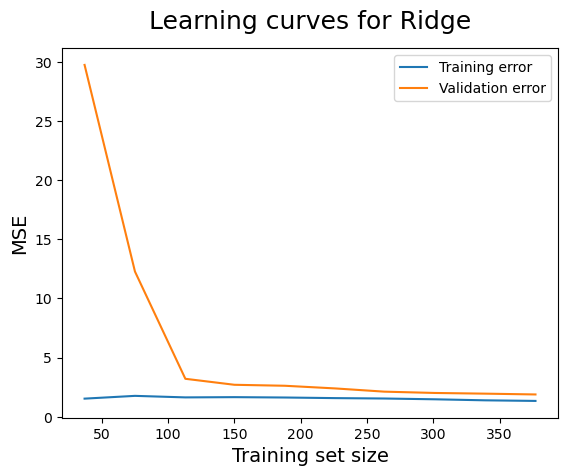

In [52]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

### Scatter Plot and Line of Best Fit
Since most points fall near the line of best fit, the model is generally accurate in predicting values. However, there are a few outliers which need to be corrected.

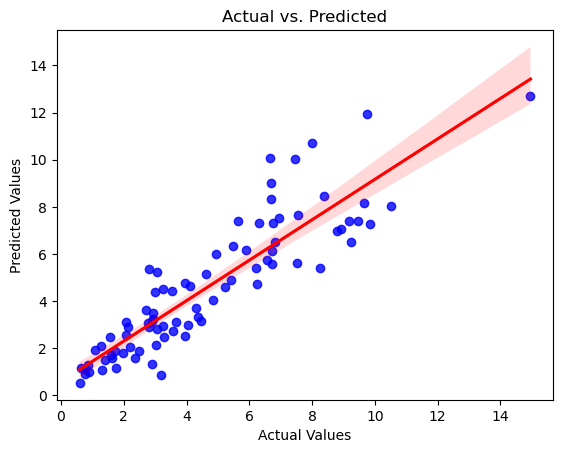

In [54]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Residual Plot
The residual plot shows more errors in predicting the clutch score are between 1 and -1. However, there are a few points outside of this range, which may be considered as outliers.

<Axes: xlabel='clutch_score'>

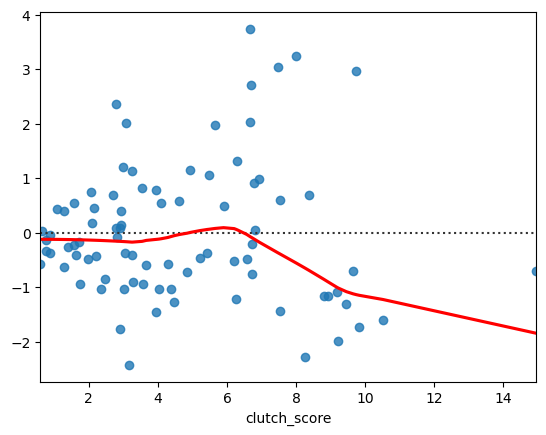

In [56]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

### Cook's Distance
Cook's distance enables us to evaluate influential points in the model. Influential points are data points that significantly change the fit of the model if removed.

As shown below, the model tends to underestimate the performance of several elite players (e.g., McDavid and Matthews) in clutch situations. These players' statistics may have created an artificial "ceiling" that limits the model’s ability to accurately predict their scoring ability in close and tied situations.

Conversely, the model overestimates the performance of other elite players (e.g., Matthew Tkachuk), who do not perform as well in clutch scoring situations as their general statistics suggest.


There are 39 influential points.
Outliers based on Cook's Distance:
                  Player  Actual  Predicted  Cook's Distance
277      Auston Matthews   14.96  12.963729         0.048987
205       David Pastrnak   13.50  10.160584         0.038814
267      Kirill Kaprizov   13.25  10.028615         0.028231
192       Leon Draisaitl   12.26   8.752896         0.039674
131       Filip Forsberg   11.44   8.562596         0.026046
301        Tage Thompson   10.64   7.516535         0.012699
37        Steven Stamkos   10.52   7.825069         0.012684
337          Josh Norris   10.00   6.079354         0.039513
198         Dylan Larkin    9.93   8.005587         0.009832
248          Roope Hintz    9.83   7.324113         0.009728
171     Nathan MacKinnon    9.75  11.539954         0.023042
333      Jason Robertson    9.66   7.907912         0.009744
176            Bo Horvat    9.61   7.620011         0.013059
112       Mark Scheifele    9.46   7.489897         0.018050
262       Artemi 

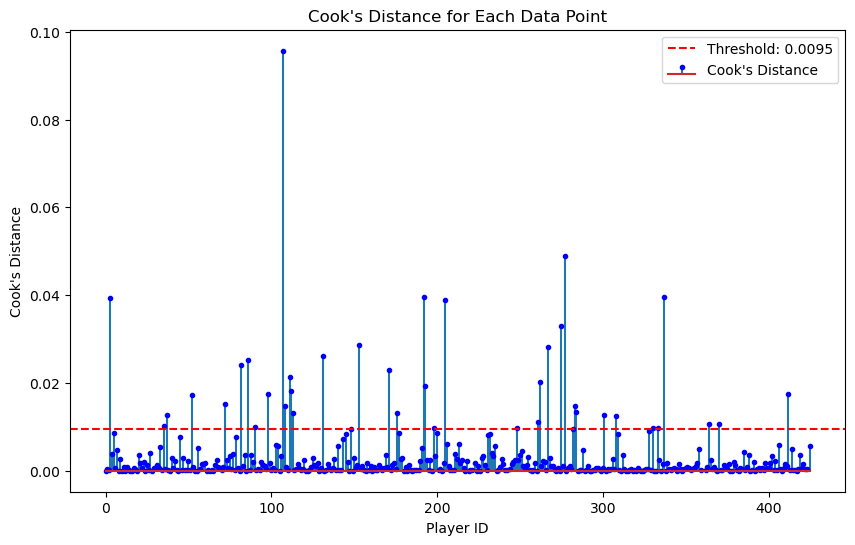

In [58]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Evaluating the Distribution of the Data

The histogram and QQ plot show that the data has a right skew distribution, which may explain why the model has difficulties in predicting the clutch score of elite players on the right side of the tail.


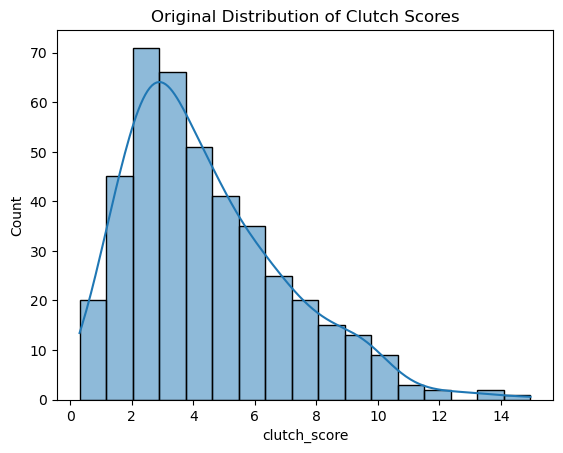

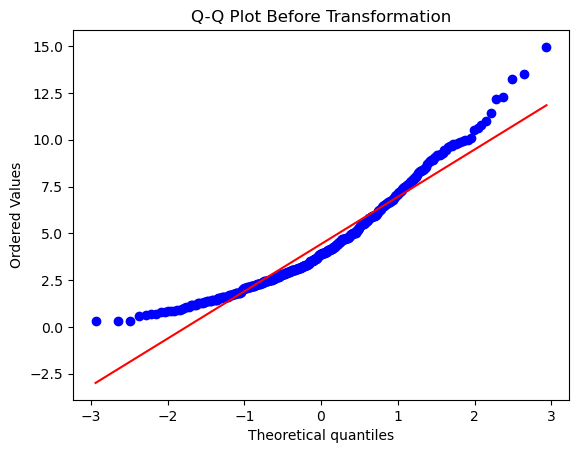

In [60]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

### Transforming the Data to a Normal Distribution with Log

As shown below, a log transformation is used to reduce the skew of the data and create a normal distribution. This ensures the predictions are not affected by the influential points we identified in Cook's distance.


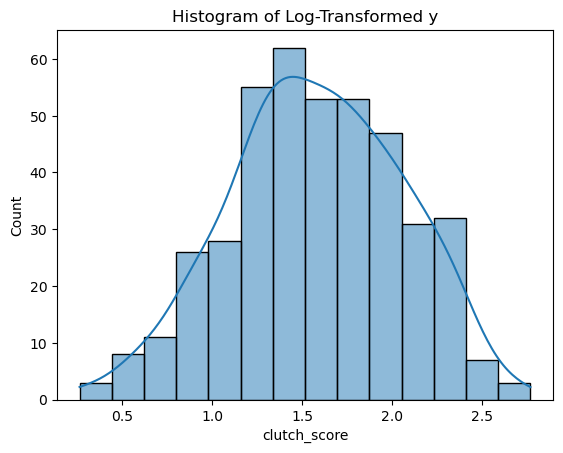

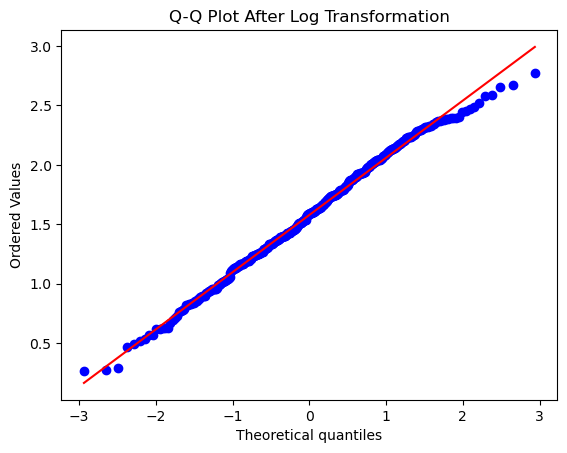

In [62]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

### Evaluating Metrics after the Log Transformation

After using a log transformation, it appears that the residuals have significantly decreased. However, it is important to remember the scale of the data has changed and we must look at the model's predictions of certain data points.

In [64]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=200
)

alphas = np.logspace(-3, 3, 20)
ridge_cv_log = RidgeCV(alphas=alphas, cv=5)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.060926944197601814
RMSE:  0.24683383924738078
MAE:  0.16244763748540536
R²:  0.726397088336697
Adjusted R²:  0.7222389893752486


### Calculating Cook's Distance 

After we apply the log transformation and calculate Cook's distance, we can see that the elite players are no longer influential points. However, there are some players which the model still struggles with. The model undervalues some players (e.g. Vrana, Laine) who may perform better in close and tied situations than their metrics suggest. On the other hand, some players are overvalued and may have better metrics that may not fully reflect their clutch performance (e.g. Matthew Tkachuk, Nikita Kucherov). While influential points are often viewed negatively, they can provide valuable insights. These points could help NHL coaching staff and management identify players who perform well in high-pressure situations, even if they aren’t considered elite based on traditional metrics.

Finally, some below-average players become influential because the log transformation tends to amplify the difference between smaller actual and predicted values.


There are 22 influential points.
Outliers based on Cook's Distance:
                Player    Actual  Predicted  Cook's Distance
337        Josh Norris  2.397895   1.945223         0.012030
107    Nikita Kucherov  2.037317   2.323783         0.015041
309    Michael Carcone  1.890095   1.259313         0.014450
412    Alexander Holtz  1.736951   1.144675         0.030971
67            Nic Dowd  1.437463   1.127307         0.010745
79       Austin Watson  1.427916   0.792459         0.028046
72    Evgeny Kuznetsov  1.403643   1.760049         0.010078
261     Evan Rodrigues  1.332366   1.827961         0.009698
86     Mikael Granlund  1.193922   1.703392         0.022121
284   Jesse Puljujarvi  1.187843   1.589896         0.017418
306   Michael Pezzetta  1.040277   0.732644         0.015157
150        Tyler Motte  0.900161   1.300086         0.010025
145       Connor Brown  0.875469   1.553427         0.014381
308  Michael Eyssimont  0.858662   1.409689         0.035956
140      Teddy Bl

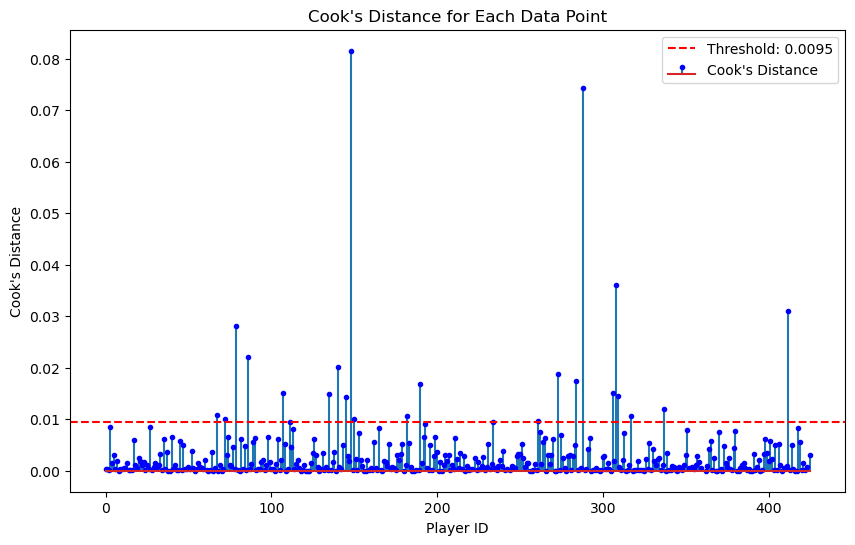

In [66]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_with_intercept)

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Final Scatter Plot from Training

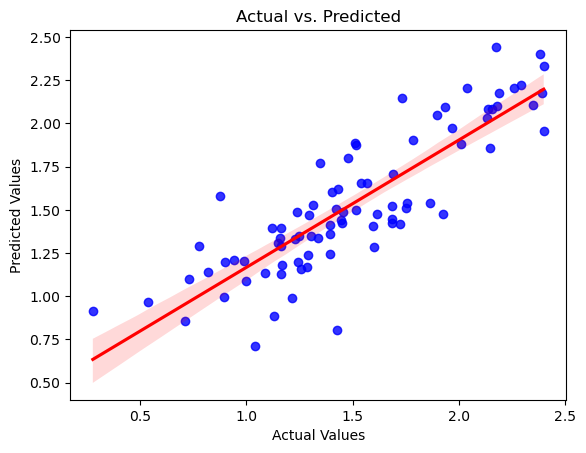

In [68]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Making Predicitons on Current Season Data

We save "ridge_cv_log" for reproductible results. We can then use it to make predictions on the current statistics of players (from 2024-2025 season to the current 2025-2026 season).

In [70]:
joblib.dump(ridge_cv_log, 'ridge_cv_model.pkl')
ridge_cv_log_loaded = joblib.load('ridge_cv_model.pkl')

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(epsilon, 'epsilon.pkl')

['epsilon.pkl']

In [71]:
all_seasons = []

for season in range(2024, 2026):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'goals': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean',
            'teamAbbrevs': 'last'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2024-2025
Successfully fetched data for season 2025-2026
      playerId  skaterFullName positionCode  gamesPlayed  goals  assists  \
0      8470600      Ryan Suter            D           82      2       13   
1      8470613     Brent Burns            D          118     11       37   
2      8470621     Corey Perry            R          111     26       19   
3      8471214   Alex Ovechkin            L          103     59       47   
4      8471215   Evgeni Malkin            C           94     24       55   
...        ...             ...          ...          ...    ...      ...   
1004   8485483  Karsen Dorwart            L            5      0        0   
1005   8485493   David Tomasek            R           22      3        2   
1006   8485511    Quinn Hutson            R            5      1        0   
1007   8485512       Tim Washe            C            2      0        0   
1008   8485702    Max Shabanov            R           25      3       

In [72]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 100)]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_game'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

In [73]:
start_season = "20242025"
end_season = "20252026"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [74]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
    "on_ice": (on_ice_url, '')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]
on_ice_df = dataframes["on_ice"]
on_ice_df.columns = on_ice_df.columns.str.replace('\xa0', ' ')

In [75]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]
on_ice_df = on_ice_df[['Player', 'Off. Zone Starts', 'On The Fly Starts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df, on_ice_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 40]

rename_columns = {
    'Shots': 'shots',
    'Rebounds Created': 'rebounds_created',
    'Off. Zone Starts': 'off_zone_starts',
    'On The Fly Starts': 'on_the_fly_starts'
}
merged_natural_stat.rename(columns = rename_columns, inplace=True)

In [76]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini", "Zack Bolduc", "Frederic Gaudreau"] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini", "Zachary Bolduc", "Freddy Gaudreau" ]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [77]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)
merged_clutch_goals_prediction = merged_clutch_goals_prediction.dropna()

In [78]:
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created', 'off_zone_starts', 'on_the_fly_starts']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [79]:
merged_clutch_goals_prediction['clutch_score'] = (
    0.45 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 
    0.35 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 
    0.2 * merged_clutch_goals_prediction['ot_goals_per_game']
)

In [80]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
91,Leon Draisaitl,15.32,1.0
144,Alex DeBrincat,11.74,2.0
240,Dylan Guenther,11.70,3.0
159,Morgan Geekie,11.34,4.0
201,Cole Caufield,11.18,5.0
152,Tage Thompson,10.88,6.0
18,John Tavares,10.80,7.0
85,Bo Horvat,10.79,8.0
2,Sidney Crosby,10.39,9.0
62,Tom Wilson,10.34,10.0


In [81]:
x_var = ['iSCF_per_game', 'assists_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 'off_zone_starts_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

scaler = joblib.load('scaler.pkl')
epsilon = joblib.load('epsilon.pkl')

X_scaled = scaler.transform(X_adjusted) 
X_scaled = np.nan_to_num(X_scaled, nan=0)

X_shifted = X_scaled + epsilon
X_log = np.log(X_shifted)

y_log = np.log(y + 1)
y_pred = ridge_cv_log_loaded.predict(X_log)

### Evaluating the Model after Testing
The R² indicates the model explains approximately 70% of variance in clutch performance, which is strong given the inherent randomness in clutch situations.

In [83]:
r2 = r2_score(y_log, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"Test Set Performance:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Test Set Performance:
R²: 0.6961
RMSE: 4.0789
MAE: 3.3402


In [84]:
y_pred = ridge_cv_log_loaded.predict(X_log)
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred 

merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 
merged_clutch_goals_prediction['log_adjusted'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) * 10
merged_clutch_goals_prediction['log_adjusted'] = merged_clutch_goals_prediction['log_adjusted'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = y_pred * 10
merged_clutch_goals_prediction = merged_clutch_goals_prediction.sort_values(by='predicted_clutch_score_adjusted', ascending = False)
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = merged_clutch_goals_prediction['predicted_clutch_score_adjusted'].apply(lambda x: round(x, 2))

### Prediction Intervals
95% prediction intervals were generated for each player. If actual clutch scores fall outside the intervals, this indicates that clutch performance is significantly different from expectations. The intervals are generated using a bootstrap procedure with resampled residual noise, which ensures that the intervals reflect randomness in clutch performance.

In [86]:
n_boot = 1000
alpha = ridge_cv_log_loaded.alpha_

boot_preds = np.zeros((n_boot, len(X_log)))  

for i in range(n_boot):
    idx = np.random.choice(len(X_log), size=len(X_log), replace=True)

    X_res = X_log[idx]
    y_res = y_log.iloc[idx]

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_res, y_res)

    preds = ridge.predict(X_log)

    residuals = y_log - ridge_cv_log_loaded.predict(X_log)
    noise = np.random.choice(residuals, size=len(X_log), replace=True)

    boot_preds[i] = preds + noise

lower_log = np.percentile(boot_preds, 2.5, axis=0)
upper_log = np.percentile(boot_preds, 97.5, axis=0)

merged_clutch_goals_prediction['lower_bound_log'] = (lower_log * 10).round(2)
merged_clutch_goals_prediction['upper_bound_log'] = (upper_log * 10).round(2)

merged_clutch_goals_prediction['Significantly_Clutch'] = np.where(
    (merged_clutch_goals_prediction['log_adjusted'] >= merged_clutch_goals_prediction['lower_bound_log']) &
    (merged_clutch_goals_prediction['log_adjusted'] <= merged_clutch_goals_prediction['upper_bound_log']),
    'Inside Range',
    'Outside Range'
)

### Shap Values

SHAP values were calculated to explain which features most influenced each player's prediction. This is useful for the dashboard since users can understand how clutch scores are predicted. 

In [88]:
explainer = shap.LinearExplainer(ridge_cv_log_loaded, X_log)
shap_values = explainer(X_log)

shap_df = pd.DataFrame(
    shap_values.values,     
    columns=X_adjusted.columns,
    index=X_adjusted.index
)

for col in shap_df.columns:
    merged_clutch_goals_prediction[f'shap_{col}'] = shap_df[col]

### Cook's Distance Observations

The model shows the same patterns as before - it undervalues and overvalues some players. Clutch scores of low performing players are also amplified by the log transformation. These players are excluded in the final dashboard by only including players with 20+ goals.

There are 16 influential points.
Outliers based on Cook's Distance:
                 Player    Actual  Predicted  Cook's Distance
91     Nathan MacKinnon  2.792391   2.220110         0.024953
231       Brayden Point  2.270062   1.721288         0.019357
138     Logan Stankoven  1.943049   1.198737         0.049412
67        Dawson Mercer  1.870263   1.422207         0.043731
116         Ridly Greig  1.690096   2.327024         0.026817
163         Ryan Strome  1.574846   1.090367         0.025114
27      Kiefer Sherwood  1.530395   1.203405         0.029848
222      Mason Appleton  1.098612   1.813425         0.031211
140        Yakov Trenin  1.098612   0.727422         0.027234
184      Colton Sissons  1.050822   1.614109         0.017673
56        Casey Cizikas  1.043804   1.500513         0.018616
134     Garnet Hathaway  0.708036   1.124384         0.017398
78   Marat Khusnutdinov  0.548121   1.055920         0.050468
61         John Beecher  0.482426   1.227215         0.050865
74

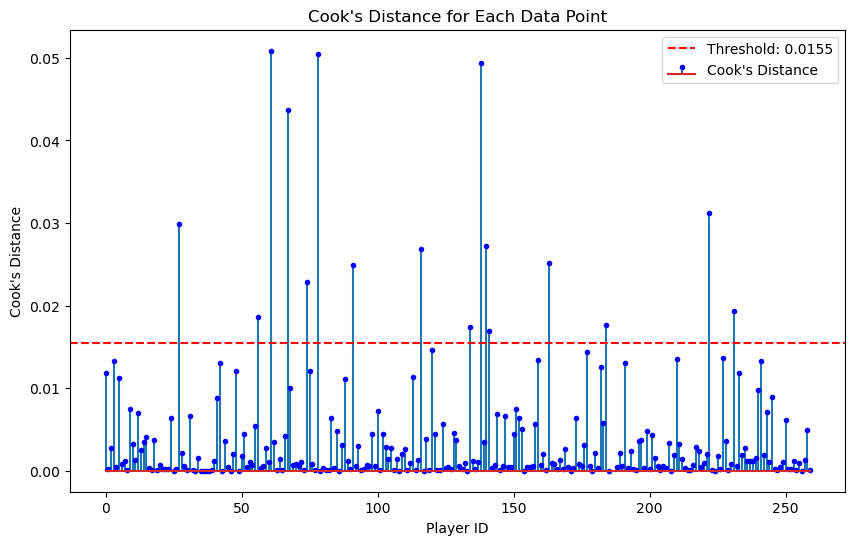

In [90]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)

merged_clutch_goals_prediction = merged_clutch_goals_prediction.iloc[:len(y_log)].copy().reset_index(drop=True)

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction['Player'].values,
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    "Cook's Distance": cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Final Scatter Plot after Testing
The Actual vs. Predicted shows a well-fitted model for clutch performance. There is a strong linear releationship and homoscedasticity. Some points may deviate from the line of best fit, but this is to be expected due to players naturally overperforming/underpeforming their clutch scores. 

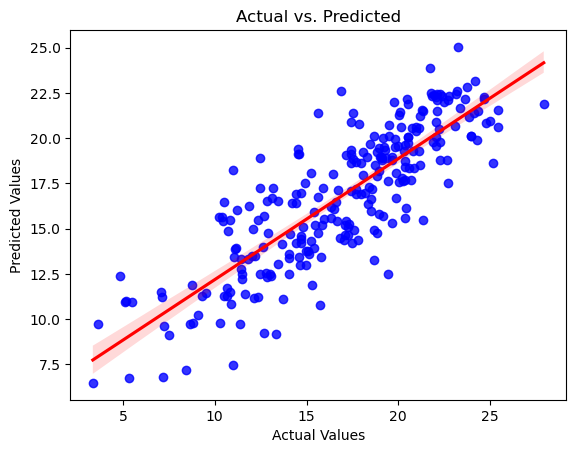

In [92]:
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log_adjusted'], y=merged_clutch_goals_prediction['predicted_clutch_score_adjusted'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [143]:
merged_clutch_goals_prediction = merged_clutch_goals_prediction.loc[merged_clutch_goals_prediction['goals'] >= 20]
merged_clutch_goals_prediction.to_csv("clutch.csv")